In [516]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats
import os
np.random.seed(42)

In [517]:
r = np.array([      # three variables: 2 objectives, 1 constraints
    [1.0, -0.32, 0.15], # Rebounds
    [-0.32, 1.0, 0.26], # Assists
    [0.15, 0.26, 1.0],  # Salary
])
    # Rebounds, Assists, Salary

n = 100_000
shape, scale = np.array([5.5408, 2.9772, 1.1701]), np.array([1.1467, 1.1295, 5157057.6371])

In [518]:
def make_pos_def(corr):
    eigvals, eigvecs = np.linalg.eigh(corr)
    eigvals[eigvals < 1e-8] = 1e-8  
    corr_pd = eigvecs @ np.diag(eigvals) @ eigvecs.T

    # normalize diagonal to 1
    d = np.sqrt(np.diag(corr_pd))
    corr_pd = corr_pd / d[:, None] / d[None, :]
    return corr_pd
r_psd = make_pos_def(r)

In [519]:
r_psd

array([[ 1.  , -0.32,  0.15],
       [-0.32,  1.  ,  0.26],
       [ 0.15,  0.26,  1.  ]])

In [520]:
mean = np.zeros(np.shape(r_psd)[0])
z = np.random.multivariate_normal(mean, r_psd, size=n)
u = stats.norm.cdf(z)


In [521]:
samples = np.zeros_like(u)
for i in range(u.shape[1]):
    samples[:, i] = stats.gamma.ppf(u[:, i], a=shape[i], scale=scale[i])

In [522]:
def transform_to_z(X, alpha, beta):
    n_samples, d = X.shape
    scales = 1.0 / beta
    U = np.zeros_like(X, dtype=float)
    for j in range(d):
        U[:, j] = stats.gamma.cdf(X[:, j], a=alpha[j], scale=scales[j])
    U = np.clip(U, 1e-12, 1 - 1e-12)
    Z = np.zeros_like(U, dtype=float)
    for j in range(d):
        Z[:, j] = stats.norm.ppf(U[:, j])
    return Z

def estimate_covariance(Z_list):
    """
    Estimate the (N*d x N*d) covariance and correlation.
    """
    Z_stacked = np.vstack([Z.ravel() for Z in Z_list])
    sigma = np.cov(Z_stacked, rowvar=False)
    R = np.corrcoef(Z_stacked, rowvar=False)
    
    return sigma, R


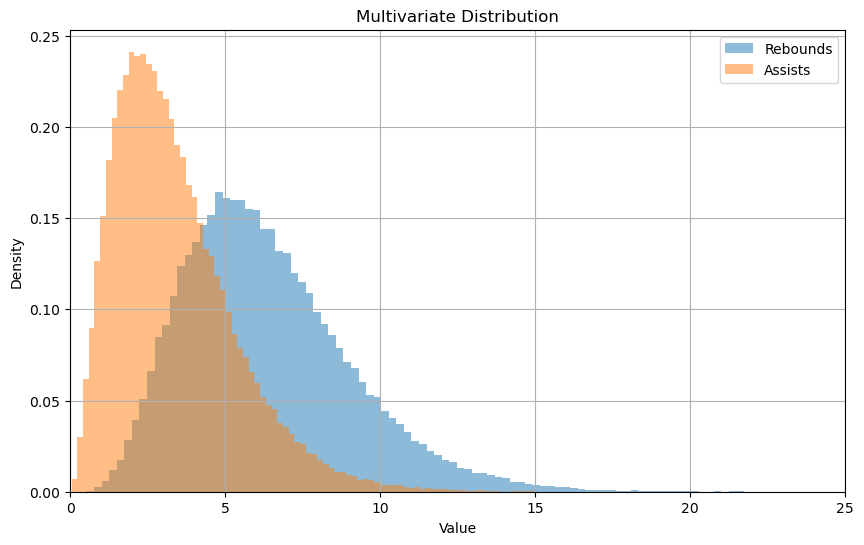

In [523]:
n_dims = samples.shape[1]
names = ["Rebounds", "Assists", "Salary"]

plt.figure(figsize=(10, 6))
for i in range(n_dims - 1):
    plt.hist(samples[:, i], bins=100, density=True, alpha=0.5, label=names[i])

# Plot salary
plt.title("Multivariate Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.xlim(0, 25)
plt.legend()
plt.grid(True)
plt.show()

In [524]:
expected_values = [a * b for a, b in zip(shape, scale)]

In [525]:
# generate data
def generate_knapsack_data(samples, shape, scale,         
                           n_items=10, max_trials=1000, exp_n_selected=5, trial_needed=100):

    # create column names (list)
    columns = (
        ['Player Number'] +
        ["Rebounds"] +
        ['Assists'] +
        ["Salary"] 
    )

    # create df with 0's
    df = pd.DataFrame(None, index=range(max_trials), columns=columns)

    valid_trials = 0
    trial_i = 0
    cursor = 0
    
    while True:
        if valid_trials >= trial_needed:
            print(f"Done: built {valid_trials} trials (needed {trial_needed}).")
            break

        if trial_i >= max_trials:
            print(f"ERROR: exceeded max_trials ({max_trials}). Built {valid_trials} trials.")
            break

        if cursor >= samples.shape[0]:
            print(f"ERROR: ran out of samples at cursor={cursor} (N={samples.shape[0]}). "
                f"Built {valid_trials} trials; attempted {trial_i} trials.")
            break
    
        # obtain unique objective and constraint values for the trial
        values = np.empty((n_items, 3), dtype=int)
        seen_obj = set()
        seen_con = set()
        item = 0
        while item < n_items:
            if cursor >= samples.shape[0]:
                print(f"ERROR: ran out of samples while filling trial {trial_i+1} "
                    f"(filled {item}/{n_items}).")
                break
            
            row = samples[cursor, :]
            cursor += 1
            obj = tuple(row[:3])

            if obj in seen_obj:
                continue

            seen_obj.add(obj)
            values[item, :]  = obj
            item += 1

        # obtain capacities for the trial
        # expected number of items selected: exp_n_selected
        cp1 = stats.gamma.rvs(a=shape[2], scale=scale[2], size=1)[0] # can sample out of the loop
        #cp2 = stats.gamma.rvs(a=shape[4], scale=scale[4], size=1)[0]
        capacity1 = cp1 * exp_n_selected
        #capacity2 = np.floor(cp2 * exp_n_selected).astype(int) 

        # check if capacity is zero
        if capacity1 == 0: #  or capacity2 == 0
            trial_i += 1
            continue

        # store data into df
        df.loc[valid_trials, 'Player Number'] = valid_trials + 1
        for i in range(n_items):
            df.loc[valid_trials, "Rebounds"] = values[i, 0]
            df.loc[valid_trials, "Assists"] = values[i, 1]
            df.loc[valid_trials, "Salary"] = values[i, 2]
    
        valid_trials += 1
        trial_i += 1


    df = df.iloc[:trial_needed].reset_index(drop=True)  


    output_dir = "./data"
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f'test_data_basketball.csv')
    '''
    if os.path.exists(output_path):
        print(f"File {output_path} already exists")
    else:
        df.to_csv(output_path, index=False)
        print(f"File {output_path} created successfully")
    '''
    df.to_csv(output_path, index=False)

In [526]:
generate_knapsack_data(samples, shape, scale,
                       n_items=20, max_trials=40, exp_n_selected=5, trial_needed=40)

Done: built 40 trials (needed 40).


In [527]:
np.corrcoef(samples.T)

array([[ 1.        , -0.29718996,  0.14086291],
       [-0.29718996,  1.        ,  0.23553269],
       [ 0.14086291,  0.23553269,  1.        ]])

In [528]:
n_items = 50
df = pd.read_csv('./data/test_data_basketball.csv')

print(np.median(df["Rebounds"]))
print(np.median(df["Assists"]))
print(np.median(df["Salary"]))

print(df)


5.0
2.0
3353442.5
    Player Number  Rebounds  Assists    Salary
0               1         4        1   4229896
1               2         5        1   1035782
2               3         2        3  18531123
3               4         5        2  10389386
4               5         3        2   3028298
5               6         6        3   1983355
6               7         4        2   1412032
7               8         1        2    184121
8               9         5        2    929075
9              10         8        1   5119529
10             11         5        3   3451356
11             12         6        3   6227931
12             13         5        2   5394198
13             14         6        1    813704
14             15         4        3    850698
15             16         4        3   3784746
16             17         6        2   5648128
17             18         3        1   1057824
18             19         6        1   1896570
19             20         3        2   728

In [529]:
"""
data = np.column_stack([df["Rebounds"], df["Assists"], df["Salary"]])

Z = transform_to_z(data, shape, 1 / scale)
Sigma, R = estimate_covariance(Z)
#R = np.around(R, 2)
print(f"R: \n{R}")

print(f"Original correlation matrix: \n{r_psd}")
"""
# Check diff in sd between runs at 300
# Do a choose 5 problem

for i in range(40, 80, 10):
    generate_knapsack_data(samples, shape, scale,
                       n_items=20, max_trials=i, exp_n_selected=5, trial_needed=i)
    df = pd.read_csv('./data/test_data_basketball.csv')
    data = np.column_stack([df["Rebounds"], df["Assists"], df["Salary"]])

    Z = transform_to_z(data, shape, 1 / scale)
    Sigma, R = estimate_covariance(Z)
    #R = np.around(R, 2)
    print(f"R: \n{R}")

print(f"Original correlation matrix: \n{r_psd}")

Done: built 40 trials (needed 40).
R: 
[[ 1.         -0.20342711  0.12031163]
 [-0.20342711  1.          0.23535933]
 [ 0.12031163  0.23535933  1.        ]]
Done: built 50 trials (needed 50).
R: 
[[ 1.         -0.29136344  0.08404337]
 [-0.29136344  1.          0.25372373]
 [ 0.08404337  0.25372373  1.        ]]
Done: built 60 trials (needed 60).
R: 
[[ 1.         -0.25448003  0.09975146]
 [-0.25448003  1.          0.29076816]
 [ 0.09975146  0.29076816  1.        ]]
Done: built 70 trials (needed 70).
R: 
[[ 1.         -0.30804019  0.21453589]
 [-0.30804019  1.          0.26961273]
 [ 0.21453589  0.26961273  1.        ]]
Original correlation matrix: 
[[ 1.   -0.32  0.15]
 [-0.32  1.    0.26]
 [ 0.15  0.26  1.  ]]


In [530]:
# reshape data for visualization
items_df_visual = pd.DataFrame()

for trial in range(len(df)):
    trial_data = []
    for item in range(1, n_items+1): 
        row = {
            'trial_number': item,
            'Rebounds': df[f'value1_item_{item}'][trial],
            'Assists': df[f'value2_item_{item}'][trial],
            'Salary': df['capacity1'][trial],
        }
        trial_data.append(row)
    items_df_visual = pd.concat([items_df_visual, pd.DataFrame(trial_data)], ignore_index=True) ## create a new sequential index

items_df_visual

KeyError: 'value1_item_1'

In [ ]:
items_df_visual.iloc[:, 1:6].corr(method='pearson')

""


c:\Users\Ilyas\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
c:\Users\Ilyas\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


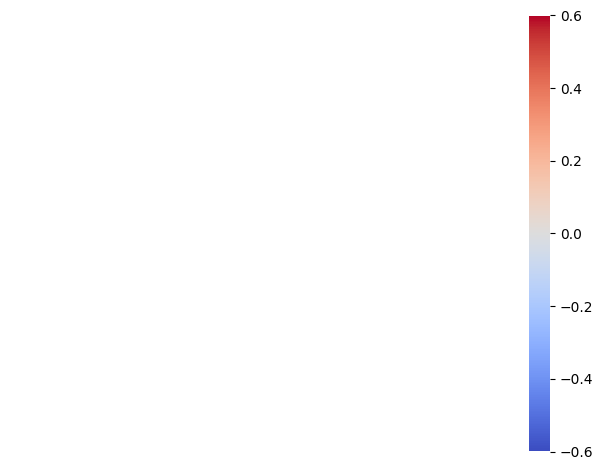

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(items_df_visual.iloc[:, 1:6].corr(method='pearson'),
            annot=True, fmt=".2f", cmap='coolwarm',vmin=-0.6,vmax =0.6)
plt.tight_layout()  
# plt.savefig("corr_matrix_50cards.png", dpi=300, bbox_inches='tight')
plt.show()

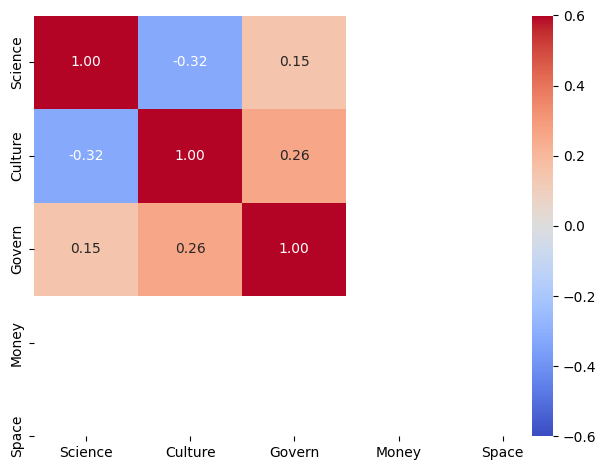

In [ ]:
labels = ["Science", "Culture", "Govern", "Money", "Space"]
sns.heatmap(r_psd, xticklabels=labels, yticklabels=labels,
            annot=True, fmt=".2f", cmap='coolwarm',vmin=-0.6,vmax =0.6)
plt.tight_layout()  # ensures labels aren’t cut off
# plt.savefig("corr_matrix_orginal.png", dpi=300, bbox_inches='tight')
plt.show()